This Homework is a part of the Deep Learning class

In this notebook, I tried an encoder-decoder technique for unsupervised learning and 2-D visualization.

The data set is the mnist dataset provided by keras

In [1]:
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(60000, 28*28).astype('float32') / 255.
x_test = x_test.reshape(10000, 28*28).astype('float32') / 255.

print('Shape of x_train: ' + str(x_train.shape)) 
print('Shape of x_test: ' + str(x_test.shape))
print('Shape of y_train: ' + str(y_train.shape))
print('Shape of y_test: ' + str(y_test.shape))

Using TensorFlow backend.


Shape of x_train: (60000, 784)
Shape of x_test: (10000, 784)
Shape of y_train: (60000,)
Shape of y_test: (10000,)


In [2]:
import numpy

def to_one_hot(y, num_class=10):
    results = numpy.zeros((len(y), num_class))
    for i, label in enumerate(y):
        results[i, label] = 1.
    return results

y_train_vec = to_one_hot(y_train)
y_test_vec = to_one_hot(y_test)

print('Shape of y_train_vec: ' + str(y_train_vec.shape))
print('Shape of y_test_vec: ' + str(y_test_vec.shape))

print(y_train[0])
print(y_train_vec[0])

Shape of y_train_vec: (60000, 10)
Shape of y_test_vec: (10000, 10)
5
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


In [3]:
rand_indices = numpy.random.permutation(60000)
train_indices = rand_indices[0:20000]
valid_indices = rand_indices[20000:30000]

x_val = x_train[valid_indices, :]
y_val = y_train_vec[valid_indices, :]

x_tr = x_train[train_indices, :]
y_tr = y_train_vec[train_indices, :]

print('Shape of x_tr: ' + str(x_tr.shape))
print('Shape of y_tr: ' + str(y_tr.shape))
print('Shape of x_val: ' + str(x_val.shape))
print('Shape of y_val: ' + str(y_val.shape))

Shape of x_tr: (20000, 784)
Shape of y_tr: (20000, 10)
Shape of x_val: (10000, 784)
Shape of y_val: (10000, 10)


Build the network

In [4]:
# build the supervised autoencoder network
from keras.layers import Dense, Input, BatchNormalization
from keras import models, regularizers

input_img = Input(shape=(784,), name='input_img')

# encoder network
encode1 = Dense(512, activation='relu', name='encode1')(input_img)
encode2 = Dense(256, activation='relu', name='encode2')(encode1)
encode3 = Dense(128, activation='relu', name='encode3')(encode2)
encode4 = Dense(32, activation='relu', name='encode4')(encode3)
encode6 = Dense(8, activation='relu', name='encode6')(encode4)

# The width of the bottleneck layer must be exactly 2.
bottleneck = Dense(2, activation='relu', name='bottleneck')(encode6)

# decoder network
decode1 = Dense(8, activation='relu', name='decode1')(bottleneck)
decode2 = Dense(32, activation='relu', name='decode2')(decode1)
decode3 = Dense(128, activation='relu', name='decode3')(decode2)
decode4 = Dense(256, activation='relu', name='decode4')(decode3)
decode5 = Dense(512, activation='relu', name='decode5')(decode4)
decode6 = Dense(784, activation='relu', name='decode6')(decode5)

# build a classifier upon the bottleneck layer
nomal1 = BatchNormalization()(bottleneck)
classifier1 = Dense(128, activation='relu', name='classifier1')(nomal1)
nomal2 = BatchNormalization()(classifier1)
classifier2 = Dense(128, activation='relu', name='classifier2')(nomal2)
nomal3 = BatchNormalization()(classifier2)
classifier5 = Dense(10, activation='softmax', activity_regularizer=regularizers.l1(5),
                    name='classifier5')(nomal3)


In [5]:
# connect the input and the two outputs
sae = models.Model(input_img, [decode6, classifier5])

sae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          (None, 784)          0                                            
__________________________________________________________________________________________________
encode1 (Dense)                 (None, 512)          401920      input_img[0][0]                  
__________________________________________________________________________________________________
encode2 (Dense)                 (None, 256)          131328      encode1[0][0]                    
__________________________________________________________________________________________________
encode3 (Dense)                 (None, 128)          32896       encode2[0][0]                    
__________________________________________________________________________________________________
encode4 (D

Train the new model and tune the hyper-parameters

In [6]:
from keras import optimizers

sae.compile(loss=['mean_squared_error', 'categorical_crossentropy'],
            loss_weights=[1, 5], # to be tuned
            optimizer=optimizers.RMSprop(lr=1E-4), metrics=['accuracy'])

history = sae.fit(x_tr, [x_tr, y_tr], 
                  batch_size=32, 
                  epochs=6, 
                  validation_data=(x_val, [x_val, y_val]))

Train on 20000 samples, validate on 10000 samples
Epoch 1/6
20000/20000 [==============================] - 14s 715us/step - loss: 165.6151 - decode6_loss: 0.0822 - classifier5_loss: 1.1066 - decode6_acc: 0.0098 - classifier5_acc: 0.6085 - val_loss: 162.9794 - val_decode6_loss: 0.0756 - val_classifier5_loss: 0.6064 - val_decode6_acc: 0.0138 - val_classifier5_acc: 0.8223
Epoch 2/6
20000/20000 [==============================] - 13s 661us/step - loss: 163.1549 - decode6_loss: 0.0747 - classifier5_loss: 0.6160 - decode6_acc: 0.0107 - classifier5_acc: 0.8085 - val_loss: 162.1405 - val_decode6_loss: 0.0736 - val_classifier5_loss: 0.4390 - val_decode6_acc: 0.0099 - val_classifier5_acc: 0.8764
Epoch 3/6
20000/20000 [==============================] - 13s 663us/step - loss: 162.3606 - decode6_loss: 0.0725 - classifier5_loss: 0.4576 - decode6_acc: 0.0097 - classifier5_acc: 0.8686 - val_loss: 161.7390 - val_decode6_loss: 0.0705 - val_classifier5_loss: 0.3593 - val_decode6_acc: 0.0105 - val_classifi

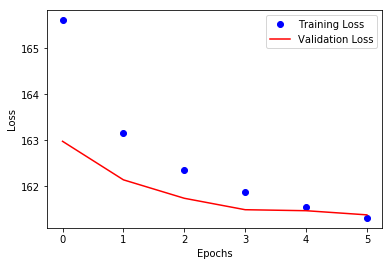

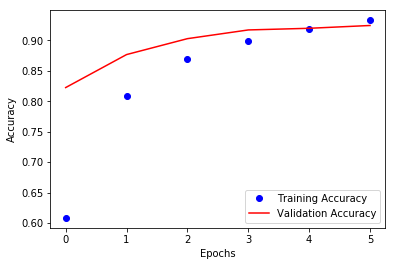

In [7]:

import matplotlib.pyplot as plt
%matplotlib inline

loss = history.history['loss']
val_loss = history.history['val_loss']

acc = history.history['classifier5_acc']
val_acc = history.history['val_classifier5_acc']

epochs = range(len(loss))

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(epochs, acc, 'bo', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

 Visualize the reconstructed test images

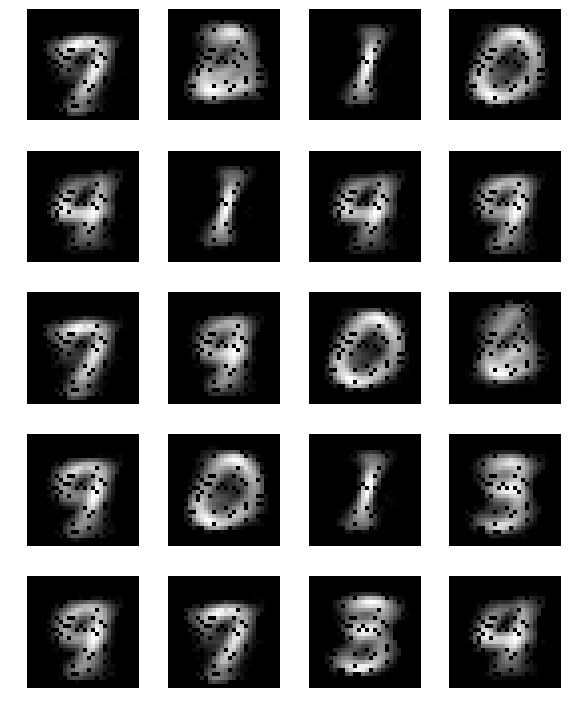

In [8]:
sae_output = sae.predict(x_test)[0].reshape((10000, 28, 28))

ROW = 5
COLUMN = 4

x = sae_output
fname = 'reconstruct_sae.pdf'

fig, axes = plt.subplots(nrows=ROW, ncols=COLUMN, figsize=(8, 10))
for ax, i in zip(axes.flat, numpy.arange(ROW*COLUMN)):
    image = x[i].reshape(28, 28)
    ax.imshow(image, cmap='gray')
    ax.axis('off')

plt.tight_layout()
plt.savefig(fname)
plt.show()

Visualize the low-dimensional features

In [9]:
# build the encoder model
sae_encoder = models.Model(input_img, bottleneck)
sae_encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_img (InputLayer)       (None, 784)               0         
_________________________________________________________________
encode1 (Dense)              (None, 512)               401920    
_________________________________________________________________
encode2 (Dense)              (None, 256)               131328    
_________________________________________________________________
encode3 (Dense)              (None, 128)               32896     
_________________________________________________________________
encode4 (Dense)              (None, 32)                4128      
_________________________________________________________________
encode6 (Dense)              (None, 8)                 264       
_________________________________________________________________
bottleneck (Dense)           (None, 2)                 18        
Total para

Shape of encoded_test: (10000, 2)


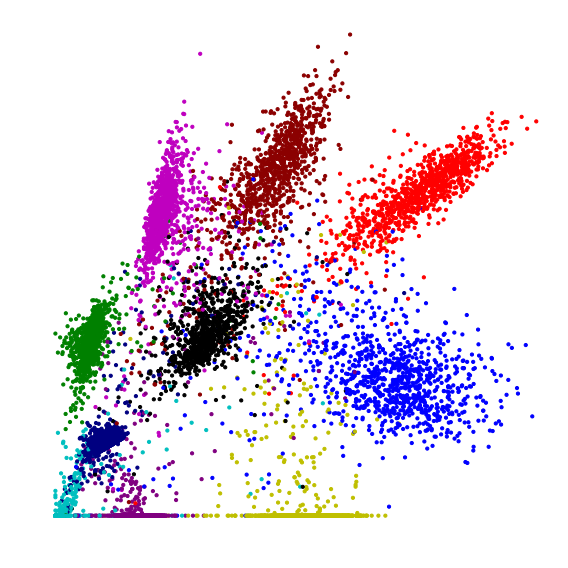

In [10]:
# extract test features
encoded_test = sae_encoder.predict(x_test)
print('Shape of encoded_test: ' + str(encoded_test.shape))

colors = numpy.array(['r', 'g', 'b', 'm', 'c', 'k', 'y', 'purple', 'darkred', 'navy'])
colors_test = colors[y_test]


import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(8, 8))
plt.scatter(encoded_test[:, 0], encoded_test[:, 1], s=10, c=colors_test, edgecolors=colors_test)
plt.axis('off')
plt.tight_layout()
fname = 'sae_code.pdf'
plt.savefig(fname)

Are the learned low-dim features discriminative?

In [11]:
# extract 2D features from the training, validation, and test samples
f_tr = sae_encoder.predict(x_tr)
f_val = sae_encoder.predict(x_val)
f_te = sae_encoder.predict(x_test)

In [12]:
f_te.shape

(10000, 2)

In [13]:
# build a classifier which takes the 2D features as input
from keras.layers import Dense, Input
from keras import models

input_feat = Input(shape=(2,))

nomal1 = BatchNormalization()(input_feat)
classifierr1 = Dense(128, activation='relu', name='classifierr1')(nomal1)
nomal2 = BatchNormalization()(classifierr1)
classifierr2 = Dense(128, activation='relu', name='classifierr2')(nomal2)
nomal3 = BatchNormalization()(classifierr2)
classifierr3 = Dense(64, activation='relu', name='classifierr3')(nomal3)

output = Dense(10, activation='softmax', activity_regularizer=regularizers.l1_l2(l1=5, l2=5),
               name='output')(classifierr3)

classifier = models.Model(input_feat, output)

classifier.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 2)                 8         
_________________________________________________________________
classifierr1 (Dense)         (None, 128)               384       
_________________________________________________________________
batch_normalization_5 (Batch (None, 128)               512       
_________________________________________________________________
classifierr2 (Dense)         (None, 128)               16512     
_________________________________________________________________
batch_normalization_6 (Batch (None, 128)               512       
_________________________________________________________________
classifierr3 (Dense)         (None, 64)                8256      
__________

In [14]:
classifier.compile(loss='categorical_crossentropy',
                  optimizer=optimizers.RMSprop(lr=1E-5),
                  metrics=['acc'])

history = classifier.fit(f_tr, y_tr, 
                        batch_size=32, 
                        epochs=30, 
                        validation_data=(f_val, y_val))

Train on 20000 samples, validate on 10000 samples
Epoch 1/50
20000/20000 [==============================] - 8s 394us/step - loss: 181.5613 - acc: 0.1308 - val_loss: 178.8254 - val_acc: 0.4017
Epoch 2/50
20000/20000 [==============================] - 7s 369us/step - loss: 178.7940 - acc: 0.3843 - val_loss: 178.2386 - val_acc: 0.7508
Epoch 3/50
20000/20000 [==============================] - 7s 369us/step - loss: 178.4965 - acc: 0.5324 - val_loss: 178.1603 - val_acc: 0.8427
Epoch 4/50
20000/20000 [==============================] - 7s 370us/step - loss: 178.4054 - acc: 0.6427 - val_loss: 178.1256 - val_acc: 0.8818
Epoch 5/50
20000/20000 [==============================] - 7s 368us/step - loss: 178.3669 - acc: 0.7026 - val_loss: 178.1123 - val_acc: 0.8932
Epoch 6/50
20000/20000 [==============================] - 7s 370us/step - loss: 178.3397 - acc: 0.7380 - val_loss: 178.1023 - val_acc: 0.9006
Epoch 7/50
20000/20000 [==============================] - 7s 369us/step - loss: 178.3200 - acc: 0.

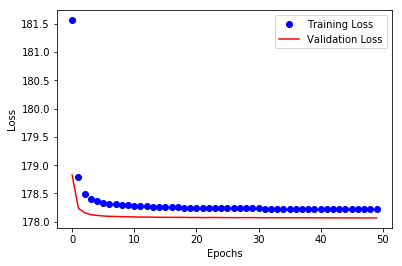

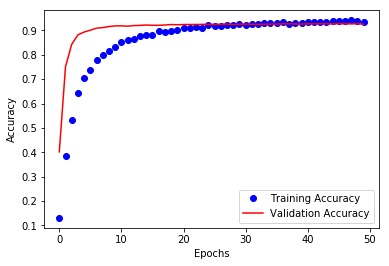

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

loss = history.history['loss']
val_loss = history.history['val_loss']

acc = history.history['acc']
val_acc = history.history['val_acc']

epochs = range(len(loss))

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(epochs, acc, 'bo', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [17]:
loss_and_acc = classifier.evaluate(f_te, y_test_vec)
print('loss = ' + str(loss_and_acc[0]))
print('accuracy = ' + str(loss_and_acc[1]))

10000/10000 [==============================] - 1s 87us/step
loss = 178.068336328125
accuracy = 0.9246
